## Exercise 6: Regression II

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

### Task 1: Logistic Regression with statsmodels

Again, we revisit the Student Performance dataset. This time however, we do not focus on predicting test performance, but on predicting whether a student has taken the test preparation course.

In [2]:
df = pd.read_csv("StudentsPerformance.csv")

#### a) Fitting and Model Analysis

Preprocess the data like in the previous exercise, i.e. transform categorical variables and remove highly correlated predictors. Then, fit a logistic regression model with statsmodels, that aims to predict the completion of a test preparation course model. Which predictors appear significant?

In [3]:
print(np.where(df.iloc[:,1:].corr() > 0.8))
# writing and reading are highly correlated!
df = df.drop("reading score", axis = 1)
df.head()

(array([0, 0, 0, 1, 1, 1, 2, 2, 2], dtype=int64), array([0, 1, 2, 0, 1, 2, 0, 1, 2], dtype=int64))


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,69,88
2,female,group B,master's degree,standard,none,90,93
3,male,group A,associate's degree,free/reduced,none,47,44
4,male,group C,some college,standard,none,76,75


In [4]:
# transform categorical to multiple dummies variables (drop one category to avoid collinearities)
X = pd.get_dummies(df[df.columns.difference(["test preparation course"])], drop_first = True)

X = sm.add_constant(X)
y = np.where(df["test preparation course"].str.contains("none"), 0, 1)

# fit model - note shorter syntax
results = sm.Logit(y, X).fit()

# print summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.519176
         Iterations 6


C:\Users\vahee\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                           13
Date:                Sat, 17 Sep 2022   Pseudo R-squ.:                  0.2040
Time:                        16:05:19   Log-Likelihood:                -519.18
converged:                       True   LL-Null:                       -652.26
Covariance Type:            nonrobust   LLR p-value:                 2.783e-49
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -6.5128      0.602    -10.819      0.000      -7.693      -5.333
math score                                       -0.1408      0.015     -9.562      0.000      -0.170      -0.112
writing score                                     0.2029      0.016     12.476      0.000       0.171       0.235
gender_male                                       2.5808      0.264      9.774      0.000       2.063       3.098
lunch_standard                                   -0.2120      0.173     -1.229      0.219      -0.550       0.126
parental level of education_bachelor's degree    -0.3618      0.271     -1.334      0.182      -0.893       0.170
parental level of education_high school           0.1344      0.244      0.552      0.581      -0.343       0.612
parental level of education_master's degree      -0.7112      0.355     -2.005      0.045      -1.406      -0.016
parental level of education_some college         -0.0260      0.227     -0.114      0.909      -0.471       0.419
parental level of education_some high school      0.7492      0.243      3.084      0.002       0.273       1.225
race/ethnicity_group B                            0.2198      0.316      0.694      0.487      -0.401       0.840
race/ethnicity_group C                            0.0452      0.294      0.154      0.878      -0.532       0.622
race/ethnicity_group D                           -0.5261      0.305     -1.725      0.085      -1.124       0.072
race/ethnicity_group E                            0.8554      0.340      2.519      0.012       0.190       1.521
=================================================================================================================
"""

#### b) Diagnostics 1: Accuracy and Confusion Matrix

Write a two function that take as input a vector y of the true classes, and a vector y_hat of the predicted classes. Let the first one return the accuracy of the prediction, i.e. the ratio of correctly predicted samples, and the second one compute the confusion matrix as introduced in class.
Apply your function on your model from a).

In [13]:
def accuracy(y,y_hat):
    """
    :param y: 1-dimensional array of true target values
    :param y_hat: 1-dimensional array of predicted target values
    :return: AUC score as float
    """
    print(y==y_hat)
    return sum(y==y_hat)*1.0/len(y)

In [14]:
y_hat = (results.predict(X) >= 0.5).astype(int)
print(accuracy(y,y_hat))

0       True
1       True
2       True
3       True
4      False
       ...  
995     True
996     True
997    False
998    False
999     True
Length: 1000, dtype: bool
0.742


In [11]:
def confusion_matrix(y,y_hat):
    """
    :param y: 1-dimensional array of true target values
    :param y_hat: 1-dimensional array of predicted target values
    :return: AUC score as float
    """
    CM = np.zeros((2,2))
    for i in range(len(y)):
        CM[y_hat[i],y[i]] +=1
    return CM

In [12]:
y_hat = (results.predict(X) >= 0.5).astype(int)
print(confusion_matrix(y,y_hat))

[[549. 165.]
 [ 93. 193.]]


#### c) Diagnostics 2: The ROC Curve

Write a function that takes as input a vector of the true classes, and a vector of the predicted probabilities resulting from the logistic regression, plots the ROC curve of the model, and returns the corresponding AUC score.
Apply your function on your model from a).

In [13]:
from matplotlib import pyplot as plt

def ROC(y, yp):
    """
    :param y: 1-dimensional array of true target values
    :param yp: 1-dimensional array of predicted target probabilities
    :return: AUC score as float
    """
    n = len(y)
    thresholds = np.sort(yp)
    TPR, FPR = np.zeros(n),np.zeros(n)
    for i in range(n):
        CM = confusion_matrix(y,(yp>=thresholds[i]).astype(int))
        FPR[i], TPR[i] = CM[1,0]/np.sum(CM[:,0]), CM[1,1]/np.sum(CM[:,1])
        
    plt.plot(FPR,TPR, color = "red")
    plt.plot([0,1],[0,1], color = "blue")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
    
    return (np.sum(TPR)/n)

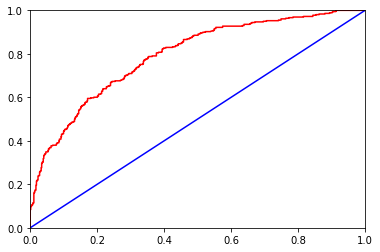

0.6877988826815642

In [14]:
ROC(y, results.predict(X))

### Example: Regression with Scikit-learn

We briefly introduce the main functionalities of the `scikit-learn` package, which we will be working with in task 2. Once again, we will revisit the Iris dataset and try to predict petal width. Note that there is an extensive documentation on the package: https://scikit-learn.org/stable/documentation.html

In [15]:
from sklearn import datasets

# import the iris dataset - it is actually incorporated in the library
iris = datasets.load_iris()

# recall the details on the dataset
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### a) Splitting training and test data

In [16]:
# predict petal width from the previous three columns
# X: Feature matrix, y: target vector
X = iris.data[:, :3]
y = iris.data[:,3]

# sklearn provides various functionalities to crossvalidate model performance
from sklearn.model_selection import train_test_split

# randomly split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 5)

#### b) Fitting a Model

In [17]:
# main precedure after having chosen the model: initialize, fit and predict
from sklearn.linear_model import LinearRegression

# initialize model - at this point you usually specify all parameters for model optimization
reg = LinearRegression(fit_intercept=True)

# fit: other than in statsmodels, training and test data are passed here
reg.fit(X_train, y_train)

print(reg.coef_)
print(reg.intercept_)

[-0.20236345  0.22293855  0.52714255]
-0.2894887294292616


#### c) Model evaluation

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation -> sklearn also provides many functionalities to mearure the 
# performance of both regressors and classifiers

# apply your model on training data
y_pred = reg.predict(X_test)

print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

# R² can also directly be computed from the model
print(reg.score(X_test,y_test))

0.03420564394660441
0.9375970738465949
0.9375970738465949


### Task 2: Predicting House Prices from Regularized Regression

In this task we want to utilize the functionalities of `sklearn` to predict house prices in the _Boston House Prices_ dataset that is also conveniently incorporated in `sklearn`. We load the data in the cell below and print its decription. Note that it is in a _bunch_ format, so that the actual data still has to be extracted. Feel free to explore the data yourself.

In [19]:
# load data and its description - feel free to further explore the data yourself
dta = datasets.load_boston()
print(dta.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### a) Splitting training and test data

We want to evaluate our models on some held-out test set. Get predictors and target variable from the bunch object, and split both into training and test set, using a 60/40 split ration. Make sure your data has been shuffled properly before splitting.

In [20]:
from sklearn.model_selection import train_test_split

X = dta.data
y = dta.target

# train_test_split has a built-in shuffling functionality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 5)

#### b) OLS regression

Fit a simple OLS model on the training data, and compute both MSE and R² score on training and test data. How would you rate the quality of your model?

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

print(mean_squared_error(y_train,y_pred))
print(r2_score(y_train,y_pred))


y_pred = reg.predict(X_test)

print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

18.89320758322978
0.7647462805122287
29.031958421325076
0.6793836995445839


**Answer**: Overall the model yields a decent $R^2$ score, and it also appears to generalize reasonably well to the test data. 

#### c) Overfitting Polynomial Models

Apply a preprocessing functionality in `sklearn` to extent your predictors to polynomials of degree 3.
Fit a new model on the new training data, and apply it on the new test data. What do you observe regarding the scores on the test data?

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 5)

In [23]:
X_train.shape

(303, 560)

In [24]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)

print(mean_squared_error(y_train,y_pred))
print(r2_score(y_train,y_pred))

4.627518179839402e-18
1.0


In [25]:

y_pred = reg.predict(X_test)

print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

10938.964433090692
-119.80515742178584


**Answer**: When training on the polynomial features, the model severely overfits to the training data as can be seen be the negative $R^2$ score and the huge MSE on the test data.

#### d) Regularization to the Rescue

To ensure that our data generalizes well, we want to apply ridge regression. This however requires that the input data has been scaled properly. Again use a preprocessing functionality in sklearn to scale your data to enable a proper fit. Be careful with the intercept when scaling the data! 

After scaling, fit a ridge regression model using the default parameters, and evaluate the model performance on the test set.
What do you observe?

In [26]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Ridge

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

reg = Ridge(alpha=1, fit_intercept=False)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

12.192888048179837
0.8653470564699144


**Answer:** Due to the regularization, the regression model suddenly generalizes very well, even achieving much better performance on the test set than before when we did not include the polynomial features. Thus, including the polynomial features added much value to the model, but without regularization, the resulting amount of features would naturally tend to overfit.

#### e) Parameter Optimization

We further want to improve our model by optimizing the regularization weight $\alpha$.
Iterate through a set of potential values $\alpha_i\in[0.001,1000]$, and based on each value $\alpha_i$, perform 10-fold cross-validation on the training set to estimate the performance of a ridge regression model with that regression weight. Determine which value $\alpha$ obtained the best cross-validated R² scores, and use this value to fit a model on the complete training data and evaluate it on the test data.  
Note that sklearn also provides a number of handy functionalities to perform cross-validation.

In [27]:
from sklearn.model_selection import cross_val_score

for alpha in [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]:
    rr = Ridge(alpha=alpha, fit_intercept=False)
    print(alpha)
    # apply sklearn's cross_val_score, which on regression models automatically outputs the R² scores for each fold. 
    # we use the mean score for each value of alpha to evaluate its ability to generalize
    print(np.mean(cross_val_score(rr, X_train_scaled, y_train, cv=5)))

0.001
0.5374907612385763
0.005
0.7129937035741862
0.01
0.7549806628828861
0.05
0.8033765963775694
0.1
0.8109455932067778
0.5
0.8207234127957885
1
0.818669330681691
5
0.770212517357783
10
0.7294378857016166
50
0.5821444476238564
100
0.47312420739773736


**Answer:** Among the values we considered, $\alpha = 0.5$ appeared to yield the cross-validated performance on the training data.  
Further, it can be observed how for lower values, the model tended to overfit, while for higher values the regression weights became too restricted to work well.

In [28]:
reg = Ridge(alpha=0.5, fit_intercept=False)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

11.092211818124762
0.877502445223167
